# IMPORTAÇÃO DE BIBLIOTECAS E FUNÇÕES

In [4]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH_TSLA = '../bds/TSLA.csv'
DATA_PATH_BYD = '../bds/BYDDY.csv'


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

def calcular_metricas_regressao(y_true, y_pred):
    # Certifique-se de que y_true e y_pred são arrays de uma única dimensão
    y_true = np.array(y_true).flatten()  
    y_pred = np.array(y_pred).flatten()
    
    # Calcula as métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Raiz do MSE
    mape = tss.mape(y_true, y_pred)
    theil = tss.theil(y_true, y_pred)
    arv = tss.arv(y_true, y_pred)
    wpocid = tss.wpocid(y_true, y_pred)
    
    # Verifica se há mais de um ponto para calcular o R²
    if len(y_true) > 1:
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))  # Coeficiente de determinação
    else:
        r2 = 'N/A'  # Não aplicável para previsões de um único ponto
    
    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'Métrica': ['MAE', 'MSE', 'MAPE','RMSE', 'R²','THEIL','ARV','WPOCID'],
        'Valor': [mae, mse, mape, rmse, r2, theil, arv, wpocid]
    })
    
    return metrics_df

In [6]:
# acf, ci = sm.tsa.acf(endog, alpha=0.05)
def getSignificantLags(y, nLags = 5, alpha=0.05):
    pac, pac_ci = sm.tsa.pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(pac)[1:].plot(kind='bar', legend='pacf',
                               xlabel='lag', ylabel='pacf');
    significantLags = []
    for i in range(1, len(pac)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if pac[i] < pac_ci[i][0] - pac[i] or pac[i] > pac_ci[i][1] - pac[i]:
            significantLags.append(i)
    print('significantLags:', significantLags)
    return significantLags

def appendLagVariables(yNm, significantLags, df, dropna=True):
    prefix = yNm.replace(')', '')
    df = df.copy()
    for lag in significantLags:
        varNm = '('+prefix+'-'+str(lag)+')'
        # nDj = pd.concat([nDj, nDj[['e1(t)']].shift(lag)], axis=1)
        df[varNm] = df[yNm].shift(lag)
        # nDj.columns = nDj.columns + [varNm]
    if dropna:
        df.dropna(axis=0, inplace=True)
    display(df.head(2))
    return df

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_adfuller(df, var_name):
    resultado_adf = adfuller(df[var_name])
    print(f'Estatística de Teste ADF: {resultado_adf[0]}')
    print(f'Valor p: {resultado_adf[1]}')
    print(f'Número de Lags usados: {resultado_adf[2]}')
    print('Valores Críticos:')
    for chave, valor in resultado_adf[4].items():
        print(f'  {chave}: {valor}')
    # Se o valor p for menor que 0.05, rejeitamos a hipótese nula e consideramos a série estacionária.
    if resultado_adf[1] < 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

# PRÉ-PROCESSAMENTO

## LEITURA DOS CSV

In [8]:
TESLA = pd.read_csv(DATA_PATH_TSLA ,sep=',',usecols=[0,4])
BYD = pd.read_csv(DATA_PATH_BYD ,sep=',',usecols=[0,4])

## TESTE DE ESTACIONARIDADE

Para muitos modelos de séries temporais como os modelos ARIMA, SARIMA e entre outros é essencial para um bom desempenho que nossa série temporal seja estacionária, mas na maioria dos casos da vida real esse objetivo não é alcançado. Quando trata-se de modelo de vida real devemos fazer ajustes e estudos para tornar a série temporal de estudo em uma série temporal estacionária, podemos checar se a série temporal é estacionária pelo teste de **Dickey-Fuller aumentado (ADF)**, caso a série temporal não seja estácionária podemos por exemplo aplicar transformação logarítimica na série temporal, que é uma estratégia amplamente usada na área de séries temporal e em específico na aplicação em séries temporais fincanceiras.

A aplicação de transformação logarítimica nos dados tem como objetivo reduzir a variância não constante dos dados.

**Hipótese nula:** A série tem uma raiz unitária (não estacionária).

- Se o p-valor for menor que 0.05, rejeitamos a hipótese nula e consideramos a série estacionária.

In [9]:
test_adfuller(TESLA, 'Close')

Estatística de Teste ADF: -2.950850254002386
Valor p: 0.03974632832027459
Número de Lags usados: 10
Valores Críticos:
  1%: -3.4369391965679257
  5%: -2.86444914142694
  10%: -2.5683189679553546
A série é estacionária.


In [10]:
test_adfuller(BYD, 'Close')

Estatística de Teste ADF: -3.7402995222571733
Valor p: 0.003580719087685793
Número de Lags usados: 0
Valores Críticos:
  1%: -3.4368734638130847
  5%: -2.8644201518188126
  10%: -2.5683035273879358
A série é estacionária.


## OBTEÇÃO DE LAGS SIGNIFICANTES

O estudo dos lags relevantes é importante para a identificação dos períodos de tempo em que a série temporal pode ser explicada por seus próprios valores passados. Com o uso da função de autocorrelação parcial (PACF), podemos capturar esses lags importante da nossa série temporal. Ao aplicar a PACF, analisamos o resultado para cada lag. Se o valor da autocorrelação parcial estiver fora do intervalo de confiança, esse lag é considerado relevante para a modelagem da série.

Seja uma série temporal $y_t$. A função de autocorrelação parcial $\phi(k)$ mede a correlação entre $y_t$ e $y_{t-k}$, removendo os efeitos dos lags intermediários $y_{t-1}, y_{t-2}, \dots, y_{t-(k-1)}$. 

Se $\phi(k)$ estiver fora do intervalo de confiança, o lag $k$ é relevante. O intervalo de confiança é dado aproximadamente por:

$$
CI = \pm z_{\alpha/2} \times \frac{1}{\sqrt{n}}
$$

Onde:
- $CI$ é o intervalo de confiança.
- $z_{\alpha/2}$ é o valor crítico da distribuição normal para o nível de significância desejado (por exemplo, para $\alpha = 0.05$,temos que $1 - \alpha/2 = 1 - 0.05/2 = 0.975$, logo:  $z_{\alpha/2} \approx 1.96$).
- $n$ é o número de observações na série.

Lags com $\phi(k)$ fora desse intervalo são considerados relevantes e podem ser usados para modelagem. 

Segue a tabela:

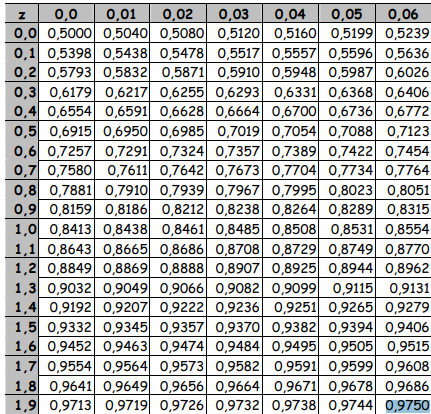

significantLags: [1, 5, 8, 10]
significantLags: [1, 53, 55, 57]


,Date,Close,(Close-1),(Close-5),(Close-8),(Close-10)
10,2020-09-16,147.253326,149.919998,122.093330,135.666672,158.350006
11,2020-09-17,141.143326,147.253326,123.779999,139.440002,149.123337


,Date,Close,(Close-1),(Close-53),(Close-55),(Close-57)
57,2020-11-20,47.450001,45.340000,20.82,21.08,22.350000
58,2020-11-23,52.650002,47.450001,20.73,20.93,22.299999


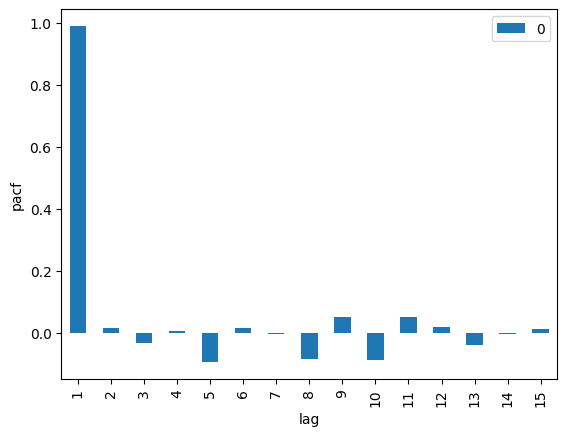

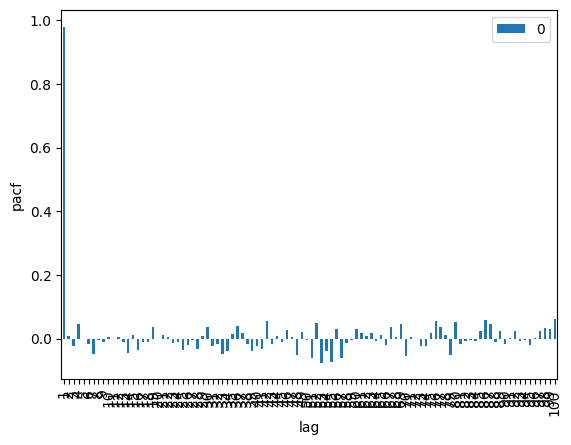

In [11]:
tesla_significantLags = getSignificantLags(y=TESLA['Close'], nLags = 15, alpha=0.05)
byd_significantLags = getSignificantLags(y=BYD['Close'], nLags = 100, alpha=0.05)

TM_tesla = appendLagVariables(yNm='Close', significantLags = tesla_significantLags, df = TESLA, dropna=True)
TM_byd = appendLagVariables(yNm='Close', significantLags = byd_significantLags, df = BYD, dropna=True)

## SEPARAÇÃO DE DADOS DE TREINAMENTO COM DADOS DE TESTE

Podemos fazer a divisão de uma série temporal da seguinte forma, seja $\{y_t\}$ a nossa série temporal, podemos dividi-la em $\{y^{train}_i\}$ e $\{y^{test}_j\}$, onde $i=1,...,m$ e $j=m,..., N$, onde $m$ é o tamanho da série de treino.

A divisão da série temporal é importante para fazer o teste de desempenho de cada modelo na seção de **processamento**, onde preveremos a partir das nossas features que são identificadas como $\{x^{test}_j\}$ e fazer o teste de desempenho de cada modelo usandos métricas adequadas com o nosso valor previsto $\{\hat{y}_i\}$ com o nosso $\{y_i\}$ verdadeiro.

In [12]:
df_tesla = TM_tesla.dropna()
# Separar features e target
X_tls = df_tesla.drop('Close', axis=1)
X_tls = X_tls.drop('Date', axis=1)
y_tls = df_tesla['Close']
# Dividir os dados em treino e teste
X_train_tesla, X_test_tesla, y_train_tesla, y_test_tesla = train_test_split(X_tls, y_tls, test_size=0.2, shuffle=False)

In [13]:
df_byd = TM_byd.dropna()
# Separar features e target
X_byd = df_byd.drop('Close', axis=1)
X_byd = X_byd.drop('Date', axis=1)
y_byd = TM_byd['Close']
# Dividir os dados em treino e teste
X_train_byd, X_test_byd, y_train_byd, y_test_byd = train_test_split(X_byd, y_byd, test_size=0.2, shuffle=False)

# PROCESSAMENTO

## Time Series Cross-Validation

A função a baixo utiliza de cross-validation para obter o melhor modelo, com base no resultado do MSE (Erro Quadrático Médio).

In [14]:
def time_series_cross_validation(X, y, model, n_splits = 25):
    tscv = TimeSeriesSplit(n_splits= n_splits)
    mse_scores = []
    best_model = None  # Para guardar o melhor modelo
    best_mse = float('inf')  # Inicializa com infinito

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
        
        # Verifica se o modelo atual é o melhor
        if mse < best_mse:
            best_mse = mse
            best_model = model  # Salva o modelo atual como o melhor

    average_mse = np.mean(mse_scores)
    print(f'MSE médio (Time Series): {average_mse}')
    print(f'Melhor MSE: {best_mse}')

    return best_model

## REGRESSÃO LINEAR

### TESLA

In [15]:
model_reglin = LinearRegression()
best_model_reglin_tsla = time_series_cross_validation(X_train_tesla, y_train_tesla, model_reglin,  n_splits = 200)

MSE médio (Time Series): 94.29588381236077
Melhor MSE: 1.5780607824505468


In [16]:
y_pred_reglin_tls = best_model_reglin_tsla.predict(X_test_tesla)

In [17]:
calcular_metricas_regressao(y_pred_reglin_tls, y_test_tesla)

,Métrica,Valor
0,MAE,5.087649
1,MSE,49.099806
2,MAPE,2.518909
3,RMSE,7.007125
4,R²,0.945355
5,THEIL,0.985106
6,ARV,0.054645
7,WPOCID,0.527638


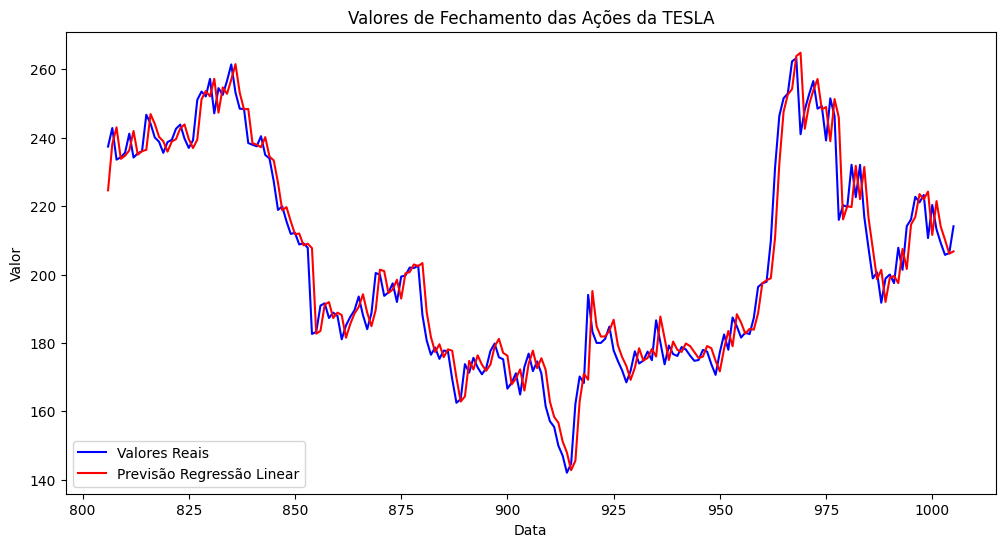

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(X_test_tesla.index, y_test_tesla, label='Valores Reais', color='blue')
plt.plot(X_test_tesla.index, y_pred_reglin_tls, label='Previsão Regressão Linear', color='red')
plt.title('Valores de Fechamento das Ações da TESLA')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

### BYD

In [19]:
best_model_reglin_byd = time_series_cross_validation(X_train_byd, y_train_byd, model_reglin,  n_splits = 200)

MSE médio (Time Series): 3.624979593340047
Melhor MSE: 0.1444656648945074


In [20]:
y_pred_reglin_byd = best_model_reglin_tsla.predict(X_test_byd)

In [21]:
calcular_metricas_regressao(y_pred_reglin_byd, y_test_byd)

,Métrica,Valor
0,MAE,0.920484
1,MSE,1.331153
2,MAPE,1.701404
3,RMSE,1.153756
4,R²,0.925486
5,THEIL,1.027619
6,ARV,0.074514
7,WPOCID,0.560847


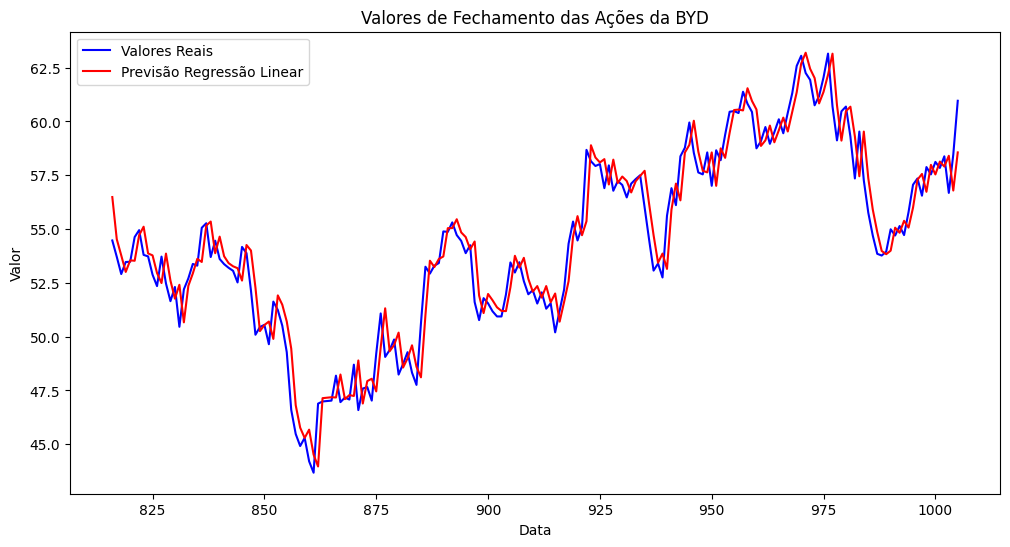

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(X_test_byd.index, y_test_byd, label='Valores Reais', color='blue')
plt.plot(X_test_byd.index, y_pred_reglin_byd, label='Previsão Regressão Linear', color='red')
plt.title('Valores de Fechamento das Ações da BYD')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

## MODELO ARIMA

In [23]:
import pmdarima as pm

In [37]:
def evaluate_arima_model(data, n_splits=5):
    # Criar um objeto TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Lista para armazenar os resultados
    mae_scores = []
    best_aic = np.inf
    best_model = None

    # Iterar sobre os splits
    for train_index, test_index in tscv.split(data):
        # Dividir os dados em conjuntos de treino e teste
        y_train = data.iloc[train_index]
        y_test = data.iloc[test_index]
        
        # Ajustar o modelo ARIMA
        model = pm.auto_arima(y_train, seasonal=False, trace=True, 
                               error_action='ignore', suppress_warnings=True)
        
        # Fazer previsões
        n_periods = len(y_test)
        forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
        
        # Calcular a métrica
        mae = mean_absolute_error(y_test, forecast)
        mae_scores.append(mae)
        
        # Checar AIC e guardar o melhor modelo
        if model.aic() < best_aic:
            best_aic = model.aic()
            best_model = model
        
        # Imprimir resultados do split atual
        print(f'Split: {len(mae_scores)}, MAE: {mae:.4f}, AIC: {model.aic()}')

    # Exibir resultados finais
    print('\nMAE Scores for each split:', mae_scores)
    print('Average MAE:', np.mean(mae_scores))
    print('Best AIC:', best_aic)
    
    return best_model

In [39]:
best_model_arima = evaluate_arima_model(y_train_tesla, 200)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1370.139, Time=3.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1372.398, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1372.999, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1372.839, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1370.859, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1376.386, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1376.185, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1374.707, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1376.740, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1376.721, Time=0.44 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1376.466, Time=0.99 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1373.256, Time=2.89 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] interc

In [40]:
y_pred_arima_tlsa = best_model_arima.predict(len(y_test_tesla))

In [41]:
calcular_metricas_regressao(y_pred_arima_tlsa, y_test_tesla)

,Métrica,Valor
0,MAE,65.374264
1,MSE,5500.981362
2,MAPE,24.071566
3,RMSE,74.168601
4,R²,-10.076933
5,THEIL,7170.150507
6,ARV,11.076933
7,WPOCID,0.507538


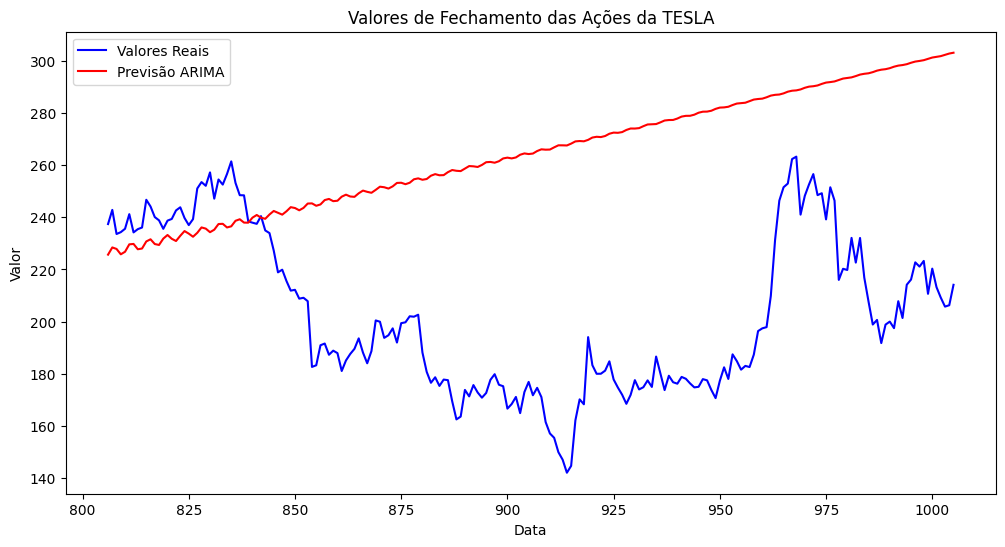

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(X_test_tesla.index, y_test_tesla, label='Valores Reais', color='blue')
plt.plot(X_test_tesla.index, y_pred_arima_tlsa, label='Previsão ARIMA', color='red')
plt.title('Valores de Fechamento das Ações da TESLA')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()